In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from astropy import units as u
from astropy.coordinates import SkyCoord
import time
from scipy import stats

# MONTE CARLO CATALOG GENERATION
The following two cells contain the necessary code to execute a 2 dimensional KS-test: <br />
The first kd2d2s-test was written by Zhaozhou Li (from https://github.com/syrte/ndtest). <br />
The second kd2d2s-test was written by Gabriel Taillon (from https://github.com/Gabinou/2DKS).

In [2]:
# https://github.com/syrte/ndtest; Zhaozhou Li
from __future__ import division
from numpy import random
from scipy.spatial.distance import pdist, cdist
from scipy.stats import kstwobign, pearsonr
from scipy.stats import genextreme

__all__ = ['ks2d2s', 'estat', 'estat2d']


def ks2d2s(x1, y1, x2, y2, nboot=None, extra=False):
    '''Two-dimensional Kolmogorov-Smirnov test on two samples. 
    Parameters
    ----------
    x1, y1 : ndarray, shape (n1, )
        Data of sample 1.
    x2, y2 : ndarray, shape (n2, )
        Data of sample 2. Size of two samples can be different.
    extra: bool, optional
        If True, KS statistic is also returned. Default is False.
    Returns
    -------
    p : float
        Two-tailed p-value.
    D : float, optional
        KS statistic. Returned if keyword `extra` is True.
    Notes
    -----
    This is the two-sided K-S test. Small p-values means that the two samples are significantly different. Note that the p-value is only an approximation as the analytic distribution is unkonwn. The approximation is accurate enough when N > ~20 and p-value < ~0.20 or so. When p-value > 0.20, the value may not be accurate, but it certainly implies that the two samples are not significantly different. (cf. Press 2007)
    References
    ----------
    Peacock, J.A. 1983, Two-Dimensional Goodness-of-Fit Testing in Astronomy, Monthly Notices of the Royal Astronomical Society, vol. 202, pp. 615-627
    Fasano, G. and Franceschini, A. 1987, A Multidimensional Version of the Kolmogorov-Smirnov Test, Monthly Notices of the Royal Astronomical Society, vol. 225, pp. 155-170
    Press, W.H. et al. 2007, Numerical Recipes, section 14.8
    '''
    assert (len(x1) == len(y1)) and (len(x2) == len(y2))
    n1, n2 = len(x1), len(x2)
    D = avgmaxdist(x1, y1, x2, y2)

    if nboot is None:
        sqen = np.sqrt(n1 * n2 / (n1 + n2))
        r1 = pearsonr(x1, y1)[0]
        r2 = pearsonr(x2, y2)[0]
        r = np.sqrt(1 - 0.5 * (r1**2 + r2**2))
        d = D * sqen / (1 + r * (0.25 - 0.75 / sqen))
        p = kstwobign.sf(d)
    else:
        n = n1 + n2
        x = np.concatenate([x1, x2])
        y = np.concatenate([y1, y2])
        d = np.empty(nboot, 'f')
        for i in range(nboot):
            idx = random.choice(n, n, replace=True)
            ix1, ix2 = idx[:n1], idx[n1:]
            #ix1 = random.choice(n, n1, replace=True)
            #ix2 = random.choice(n, n2, replace=True)
            d[i] = avgmaxdist(x[ix1], y[ix1], x[ix2], y[ix2])
        p = np.sum(d > D).astype('f') / nboot
    if extra:
        return p, D
    else:
        return p


def avgmaxdist(x1, y1, x2, y2):
    D1 = maxdist(x1, y1, x2, y2)
    D2 = maxdist(x2, y2, x1, y1)
    return (D1 + D2) / 2


def maxdist(x1, y1, x2, y2):
    n1 = len(x1)
    D1 = np.empty((n1, 4))
    for i in range(n1):
        a1, b1, c1, d1 = quadct(x1[i], y1[i], x1, y1)
        a2, b2, c2, d2 = quadct(x1[i], y1[i], x2, y2)
        D1[i] = [a1 - a2, b1 - b2, c1 - c2, d1 - d2]

    # re-assign the point to maximize difference,
    # the discrepancy is significant for N < ~50
    D1[:, 0] -= 1 / n1

    dmin, dmax = -D1.min(), D1.max() + 1 / n1
    return max(dmin, dmax)


def quadct(x, y, xx, yy):
    n = len(xx)
    ix1, ix2 = xx <= x, yy <= y
    a = np.sum(ix1 & ix2) / n
    b = np.sum(ix1 & ~ix2) / n
    c = np.sum(~ix1 & ix2) / n
    d = 1 - a - b - c
    return a, b, c, d


def estat2d(x1, y1, x2, y2, **kwds):
    return estat(np.c_[x1, y1], np.c_[x2, y2], **kwds)


def estat(x, y, nboot=1000, replace=False, method='log', fitting=False):
    '''
    Energy distance statistics test.
    Reference
    ---------
    Aslan, B, Zech, G (2005) Statistical energy as a tool for binning-free
      multivariate goodness-of-fit tests, two-sample comparison and unfolding.
      Nuc Instr and Meth in Phys Res A 537: 626-636
    Szekely, G, Rizzo, M (2014) Energy statistics: A class of statistics
      based on distances. J Stat Planning & Infer 143: 1249-1272
    Brian Lau, multdist, https://github.com/brian-lau/multdist
    '''
    n, N = len(x), len(x) + len(y)
    stack = np.vstack([x, y])
    stack = (stack - stack.mean(0)) / stack.std(0)
    if replace:
        rand = lambda x: random.randint(x, size=x)
    else:
        rand = random.permutation

    en = energy(stack[:n], stack[n:], method)
    en_boot = np.zeros(nboot, 'f')
    for i in range(nboot):
        idx = rand(N)
        en_boot[i] = energy(stack[idx[:n]], stack[idx[n:]], method)

    if fitting:
        param = genextreme.fit(en_boot)
        p = genextreme.sf(en, *param)
        return p, en, param
    else:
        p = (en_boot >= en).sum() / nboot
        return p, en, en_boot


def energy(x, y, method='log'):
    dx, dy, dxy = pdist(x), pdist(y), cdist(x, y)
    n, m = len(x), len(y)
    if method == 'log':
        dx, dy, dxy = np.log(dx), np.log(dy), np.log(dxy)
    elif method == 'gaussian':
        raise NotImplementedError
    elif method == 'linear':
        pass
    else:
        raise ValueError
    z = dxy.sum() / (n * m) - dx.sum() / n**2 - dy.sum() / m**2
    # z = ((n*m)/(n+m)) * z # ref. SR
    return z

In [3]:
# Code créé par Gabriel Taillon le 7 Mai 2018
#  Kolmogorov-Smyrnov Test extended to two dimensions.
# References:s
#  [1] Peacock, J. A. (1983). Two-dimensional goodness-of-fit testing
#  in astronomy. Monthly Notices of the Royal Astronomical Society,
#  202(3), 615-627.
#  [2] Fasano, G., & Franceschini, A. (1987). A multidimensional version of
#  the Kolmogorov–Smirnov test. Monthly Notices of the Royal Astronomical
#  Society, 225(1), 155-170.
#  [3] Flannery, B. P., Press, W. H., Teukolsky, S. A., & Vetterling, W.
#  (1992). Numerical recipes in C. Press Syndicate of the University
#  of Cambridge, New York, 24, 78.
import sys
import inspect
import scipy.stats

def CountQuads(Arr2D, point):
    """ Computes the probabilities of finding points in each 4 quadrant
    defined by a vertical and horizontal lines crossing the point, by counting
    the proportion of points in Arr2D in each quadrant.
    :param list Arr2D: Array of points to be counted.
    :param array point: A 2 element list, point, which is the center of
    4 square quadrants.
    :returns: a tuple of 4 floats.  The probabilities of finding a point in
    each quadrants, with point as the origin.  p stands for positive, n for
    negative, with the first and second positions meaning the x and y
    directions respectively.
    """
    if isinstance(point, list):
        point = np.asarray((np.ravel(point)))
    elif type(point).__module__+type(point).__name__ == 'numpyndarray':
        point = np.ravel(point.copy())
    else:
        raise TypeError('Input point is neither list nor numpyndarray')
    if len(point) != 2:
        return
    if isinstance(Arr2D, list):
        Arr2D = np.asarray((Arr2D))
    elif type(Arr2D).__module__+type(Arr2D).__name__ == 'numpyndarray':
        pass
    else:
        raise TypeError('Input Arr2D is neither list nor numpyndarray')
    if Arr2D.shape[1] > Arr2D.shape[0]:  # Reshape to A[row,column]
        Arr2D = Arr2D.copy().T
    if Arr2D.shape[1] != 2:
        raise TypeError('Input Arr2D is not 2D')
    # The pp of Qpp refer to p for 'positive' and n for 'negative' quadrants.
    # In order. first subscript is x, second is y.
    Qpp = Arr2D[(Arr2D[:, 0] > point[0]) & (Arr2D[:, 1] > point[1]), :]
    Qnp = Arr2D[(Arr2D[:, 0] < point[0]) & (Arr2D[:, 1] > point[1]), :]
    Qpn = Arr2D[(Arr2D[:, 0] > point[0]) & (Arr2D[:, 1] < point[1]), :]
    Qnn = Arr2D[(Arr2D[:, 0] < point[0]) & (Arr2D[:, 1] < point[1]), :]
    # Normalized fractions:
    ff = 1./len(Arr2D)
    fpp = len(Qpp)*ff
    fnp = len(Qnp)*ff
    fpn = len(Qpn)*ff
    fnn = len(Qnn)*ff
    # NOTE:  all the f's are supposed to sum to 1.0. Float representation
    # cause SOMETIMES sum to 1.000000002 or something. I don't know how to
    # test for that reliably, OR what to do about it yet. Keep in mind.
    return(fpp, fnp, fpn, fnn)


def FuncQuads(func2D, point, xlim, ylim, rounddig=4):
    """ Computes the probabilities of finding points in each 4 quadrant
    defined by a vertical and horizontal lines crossing the point, by
    integrating the density function func2D in each quadrant.
    :param array func2D: Density function that takes 2 arguments: x and y.
    :param list point: A 2 element list, point, which is the center of 4
    square quadrants.
    :param array xlim,ylim: Domain of numerical integration necessary to
    compute the quadrant probabilities.
    :returns: a tuple of 4 floats. The probabilities of finding a point in
    each quadrants, with point as the origin.  p stands for positive,
    n for negative, with the first and second positions meaning the x and y
    directions respectively.
    """
    if callable(func2D):
        if len(inspect.getfullargspec(func2D)[0]) != 2:
            raise TypeError('Input func2D is not a function with 2 arguments')
        pass
    else:
        raise TypeError('Input func2D is not a function')
    # If xlim, ylim and point are not lists or ndarray, exit.
    if isinstance(point, list):
        point = np.asarray((np.ravel(point)))
    elif type(point).__module__+type(point).__name__ == 'numpyndarray':
        point = np.ravel(point.copy())
    else:
        raise TypeError('Input point is not a list or numpyndarray')
    if len(point) != 2:
        raise TypeError('Input point has not exactly 2 elements')
    if isinstance(xlim, list):
        xlim = np.asarray((np.sort(np.ravel(xlim))))
    elif type(xlim).__module__+type(xlim).__name__ == 'numpyndarray':
        xlim = np.sort(np.ravel(xlim.copy()))
    else:
        raise TypeError('Input xlim is not a list or ndarray')
    if len(xlim) != 2:
        raise TypeError('Input xlim has not exactly 2 elements')
    if xlim[0] == xlim[1]:
        raise TypeError('Input xlim[0] should be different to xlim[1]')
    if isinstance(ylim, list):
        ylim = np.asarray((np.sort(np.ravel(ylim))))
    elif type(ylim).__module__+type(ylim).__name__ == 'numpyndarray':
        ylim = np.sort(np.ravel(ylim.copy()))
    else:
        raise TypeError('Input ylim is not a list or ndarray')
    if len(ylim) != 2:
        raise TypeError('Input ylim has not exactly 2 elements')
    if ylim[0] == ylim[1]:
        raise TypeError('Input ylim[0] should be different to ylim[1]')
    # Numerical integration to find the quadrant probabilities.
    totInt = scipy.integrate.dblquad(func2D, *xlim,
                                     lambda x: np.amin(ylim),
                                     lambda x: np.amax(ylim))[0]
    Qpp = scipy.integrate.dblquad(func2D, point[0], np.amax(xlim),
                                  lambda x: point[1],
                                  lambda x: np.amax(ylim))[0]
    Qpn = scipy.integrate.dblquad(func2D, point[0], np.amax(xlim),
                                  lambda x: np.amin(ylim),
                                  lambda x: point[1])[0]
    Qnp = scipy.integrate.dblquad(func2D, np.amin(xlim), point[0],
                                  lambda x: point[1],
                                  lambda x: np.amax(ylim))[0]
    Qnn = scipy.integrate.dblquad(func2D, np.amin(xlim), point[0],
                                  lambda x: np.amin(ylim),
                                  lambda x: point[1])[0]
    fpp = round(Qpp/totInt, rounddig)
    fnp = round(Qnp/totInt, rounddig)
    fpn = round(Qpn/totInt, rounddig)
    fnn = round(Qnn/totInt, rounddig)
    return(fpp, fnp, fpn, fnn)


def Qks(alam, iter=100, prec=1e-17):
    """ Computes the value of the KS probability function, as a function of
    alam, the D statistic. From *Numerical recipes in C* page 623: '[...]
    the K–S statistic useful is that its distribution in the case of the null
    hypothesis (data sets drawn from the same distribution) can be calculated,
    at least to useful approximation, thus giving the significance of any
    observed nonzero value of D.' (D being the KS statistic).
    :param float alam: D statistic.
    :param int iter: Number of iterations to be perfomed. On non-convergence,
    returns 1.0.
    :param float prec: Convergence criteria of the qks. Stops converging if
    that precision is attained.
    :returns: a float. The significance level of the observed D statistic.
    """
    # If j iterations are performed, meaning that toadd
    # is still 2 times larger than the precision.
    if isinstance(alam, int) | isinstance(alam, float):
        pass
    else:
        raise TypeError('Input alam is neither int nor float')
    toadd = [1]
    qks = 0.
    j = 1
    while (j < iter) & (abs(toadd[-1]) > prec*2):
        toadd.append(2.*(-1.)**(j-1.)*np.exp(-2.*j**2.*alam**2.))
        qks += toadd[-1]
        j += 1
    if (j == iter) | (qks > 1):  # If no convergence after j iter, return 1.0
        return(1.0)
    if qks < prec:
        return(0.)
    else:
        return(qks)


def ks2d2s_2(Arr2D1, Arr2D2):
    """ ks stands for Kolmogorov-Smirnov, 2d for 2 dimensional,
    2s for 2 samples.
    KS test for goodness-of-fit on two 2D samples. Tests the hypothesis that
    the two samples are from the same distribution.
    :param array Arr2D1: 2D array of points/samples.
    :param array Arr2D2: 2D array of points/samples.
    :returns: a tuple of two floats. First, the two-sample K-S statistic.
    If this value is higher than the significance level of the hypothesis,
    it is rejected. Second, the significance level of *d*. Small values of
    prob show that the two samples are significantly different.
    """
    if type(Arr2D1).__module__+type(Arr2D1).__name__ == 'numpyndarray':
        pass
    else:
        raise TypeError('Input Arr2D1 is neither list nor numpyndarray')
    if Arr2D1.shape[1] > Arr2D1.shape[0]:
        Arr2D1 = Arr2D1.copy().T
    if type(Arr2D2).__module__+type(Arr2D2).__name__ == 'numpyndarray':
        pass
    else:
        raise TypeError('Input Arr2D2 is neither list nor numpyndarray')
    if Arr2D2.shape[1] > Arr2D2.shape[0]:
        Arr2D2 = Arr2D2.copy().T
    if Arr2D1.shape[1] != 2:
        raise TypeError('Input Arr2D1 is not 2D')
    if Arr2D2.shape[1] != 2:
        raise TypeError('Input Arr2D2 is not 2D')
    d1, d2 = 0., 0.
    for point1 in Arr2D1:
        fpp1, fmp1, fpm1, fmm1 = CountQuads(Arr2D1, point1)
        fpp2, fmp2, fpm2, fmm2 = CountQuads(Arr2D2, point1)
        d1 = max(d1, abs(fpp1-fpp2))
        d1 = max(d1, abs(fpm1-fpm2))
        d1 = max(d1, abs(fmp1-fmp2))
        d1 = max(d1, abs(fmm1-fmm2))
    for point2 in Arr2D2:
        fpp1, fmp1, fpm1, fmm1 = CountQuads(Arr2D1, point2)
        fpp2, fmp2, fpm2, fmm2 = CountQuads(Arr2D2, point2)
        d2 = max(d2, abs(fpp1-fpp2))
        d2 = max(d2, abs(fpm1-fpm2))
        d2 = max(d2, abs(fmp1-fmp2))
        d2 = max(d2, abs(fmm1-fmm2))
    d = (d1+d2)/2.
    sqen = np.sqrt(len(Arr2D1)*len(Arr2D2)/(len(Arr2D1)+len(Arr2D2)))
    R1 = scipy.stats.pearsonr(Arr2D1[:, 0], Arr2D1[:, 1])[0]
    R2 = scipy.stats.pearsonr(Arr2D2[:, 0], Arr2D2[:, 1])[0]
    RR = np.sqrt(1.-(R1*R1+R2*R2)/2.)
    prob = Qks(d*sqen/(1.+RR*(0.25-0.75/sqen)))
    # Small values of prob show that the two samples are significantly
    # different. Prob is the significance level of an observed value of d.
    # NOT the same as the significance level that ou set and compare to D.
    return(d, prob)


def ks2d1s(Arr2D, func2D, xlim=[], ylim=[]):
    """ ks stands for Kolmogorov-Smirnov, 2d for 2 dimensional,
    1s for 1 sample.
    KS test for goodness-of-fit on one 2D sample and one 2D density
    distribution. Tests the hypothesis that the data was generated
    from the density distribution.
    :param array Arr2D: 2D array of points/samples.
    :param func2D: Density distribution. Could implement a function for
    arrays in the future...
    :param array xlim, ylim: Defines the domain for the numerical integration
    necessary to compute the quadrant probabilities.
    :returns: tuple of two floats. First, the two-sample K-S statistic.
    If this value is higher than the significance level of the hypothesis,
    it is rejected. Second, the significance level of *d*. Small values of
    prob show that the two samples are significantly different.
    """
    if callable(func2D):
        if len(inspect.getfullargspec(func2D)[0]) != 2:
            raise TypeError('Input func2D is not a function with 2 input arguments')
        pass
    else:
        raise TypeError('Input func2D is not a function')
    if type(Arr2D).__module__+type(Arr2D).__name__ == 'numpyndarray':
        pass
    else:
        raise TypeError('Input Arr2D is neither list nor numpyndarray')
    print(Arr2D.shape)
    if Arr2D.shape[1] > Arr2D.shape[0]:
        Arr2D = Arr2D.copy().T
    if Arr2D.shape[1] != 2:
        raise TypeError('Input Arr2D is not 2D')
    if xlim == []:
        xlim.append(np.amin(Arr2D[:, 0]) -
                    abs(np.amin(Arr2D[:, 0]) -
                    np.amax(Arr2D[:, 0]))/10)
        xlim.append(np.amax(Arr2D[:, 0]) -
                    abs(np.amin(Arr2D[:, 0]) -
                    np.amax(Arr2D[:, 0]))/10)
    if ylim == []:
        ylim.append(np.amin(Arr2D[:, 1]) -
                    abs(np.amin(Arr2D[:, 1]) -
                    np.amax(Arr2D[:, 1]))/10)

        ylim.append(np.amax(Arr2D[:, 1]) -
                    abs(np.amin(Arr2D[:, 1]) -
                    np.amax(Arr2D[:, 1]))/10)
    d = 0
    for point in Arr2D:
        fpp1, fmp1, fpm1, fmm1 = FuncQuads(func2D, point, xlim, ylim)
        fpp2, fmp2, fpm2, fmm2 = CountQuads(Arr2D, point)
        d = max(d, abs(fpp1-fpp2))
        d = max(d, abs(fpm1-fpm2))
        d = max(d, abs(fmp1-fmp2))
        d = max(d, abs(fmm1-fmm2))
    sqen = np.sqrt(len(Arr2D))
    R1 = scipy.stats.pearsonr(Arr2D[:, 0], Arr2D[:, 1])[0]
    RR = np.sqrt(1.0-R1**2)
    prob = Qks(d*sqen/(1.+RR*(0.25-0.75/sqen)))
    return d, prob

 <br /> 
 <br />
 <br />
 
## Now read in the blazar catalog data:

In [4]:
df = pd.read_csv("/mnt/c/Users/joerg/OneDrive/Dokumente/UNI/Bachelor of Science/Bachelorarbeit/Jupyter Notebook/blazar_clean.csv")
del df["Unnamed: 0"], df["SOURCE_NUMBER"], df["NAME"], df["REDSHIFT"], df["REDSHIFT_FLAG"], df["FLUX_1P4_GHZ"], df["RMAG"], df["XRAY_FLUX"], df["OBJECT_TYPE"], df["FLUX_143_GHZ"], df["GR_PHOTON_FLUX"], df["RO_SPECTRAL_INDEX"], df["l"], df["b"]
df

,RA,DEC
0,186.861167,-44.610639
1,181.245458,-50.932389
2,169.612292,-46.570828
3,195.917792,-46.350639
4,216.295708,-46.081639
...,...,...
1172,297.947750,-5.162219
1173,304.740667,-5.158169
1174,313.847417,-5.105358
1175,40.233958,-5.078328


## MC catalog generation algorithm:
Stored in a dictionary (called a), wherein every entry contains a different newly generated catalog. <br /> <br />
Every catalog is generated by adding (small) random values to the RA and DEC of the coordinates. <br />
To maintain the same number of blazars inside the boundaries (1177 blazars), the blazars which were shifted outside the boundaries get shifted back in. <br /> <br />
Finally a ks2d2s-test (here the test by Zhaozhou Li is used, see the application of the other test by Gabriel Taillon below) is performed for each generated catalog to verify the conservation of the statistical distribution.

In [5]:
a={}
for i in range(10): # Put the number of catalogs to be generated into this range()-function
    t0 = time.time()
    a[i] = (np.array([z+random.uniform(-10, 10) for z in df["RA"].tolist()]), np.array([z+random.uniform(-5, 5) for z in df["DEC"].tolist()]))
    a_gal = SkyCoord(ra=a[i][0]*u.degree, dec=a[i][1]*u.degree, frame="icrs").galactic
    for j in range(1177):
# Shift all blazars near the galactic plane into the boundaries:
        if 0 < a_gal.b.value[j] < 10:
            a[i][1][j] = SkyCoord(l = a_gal.l.value[j]*u.degree, b = (a_gal.b.value[j] + 10)*u.degree, frame="galactic").icrs.dec.value
            a[i][0][j] = SkyCoord(l = a_gal.l.value[j]*u.degree, b = (a_gal.b.value[j] + 10)*u.degree, frame="galactic").icrs.ra.value
        if -10 < a_gal.b.value[j] < 0:
            a[i][1][j] = SkyCoord(l = a_gal.l.value[j]*u.degree, b = (a_gal.b.value[j] - 10)*u.degree, frame="galactic").icrs.dec.value
            a[i][0][j] = SkyCoord(l = a_gal.l.value[j]*u.degree, b = (a_gal.b.value[j] - 10)*u.degree, frame="galactic").icrs.ra.value
# Shift all blazars outside the outer boundaries back inside:
        if a[i][1][j] > -5:
            a[i][1][j] = a[i][1][j] - 5
        if a[i][1][j] < -85:
            a[i][1][j] = a[i][1][j] + 5
        if a[i][0][j] > 360:
            a[i][0][j] = a[i][0][j] - 10
        if a[i][0][j] < 0:
            a[i][0][j] = a[i][0][j] + 10
# If the previous shifting of blazars near the galactic plane causes a blazar to be above the equatorial plane, this will shift it back down:            
        if a[i][1][j] > -5:
            a[i][1][j] = a[i][1][j] - 5
    print(f'kstest result: ({ks2d2s(df.to_numpy()[:,0], df.to_numpy()[:,1], a[i][0], a[i][1], extra=True)[0]:.4f}, {ks2d2s(df.to_numpy()[:,0], df.to_numpy()[:,1], a[i][0], a[i][1], extra=True)[1]:.4f})    euclidean distance: {np.linalg.norm(np.array((df.to_numpy()[0,0], df.to_numpy()[0,1])) - np.array((a[i][0][0], a[i][1][0]))):.2f}    distance (RA): {np.linalg.norm(df.to_numpy()[0,0] - a[i][0][0]):.2f}    distance (DEC): {np.linalg.norm(df.to_numpy()[0,1] - a[i][1][0]):.2f}')
    t1 = time.time()
    print(f"The MC catalog generation took: {t1-t0:.3f}s")

kstest result: (0.9315, 0.0272)    euclidean distance: 7.84    distance (RA): 7.83    distance (DEC): 0.27
The MC catalog generation took: 0.877s
kstest result: (0.9591, 0.0255)    euclidean distance: 6.85    distance (RA): 6.56    distance (DEC): 1.95
The MC catalog generation took: 0.772s
kstest result: (0.9924, 0.0217)    euclidean distance: 9.33    distance (RA): 9.25    distance (DEC): 1.23
The MC catalog generation took: 0.698s
kstest result: (0.5254, 0.0408)    euclidean distance: 5.08    distance (RA): 5.03    distance (DEC): 0.72
The MC catalog generation took: 0.637s
kstest result: (0.8750, 0.0297)    euclidean distance: 4.86    distance (RA): 2.69    distance (DEC): 4.05
The MC catalog generation took: 0.663s
kstest result: (0.8640, 0.0302)    euclidean distance: 4.64    distance (RA): 3.75    distance (DEC): 2.74
The MC catalog generation took: 0.703s
kstest result: (0.7906, 0.0327)    euclidean distance: 9.19    distance (RA): 8.15    distance (DEC): 4.26
The MC catalog ge

Plot one of the generated catalogs:

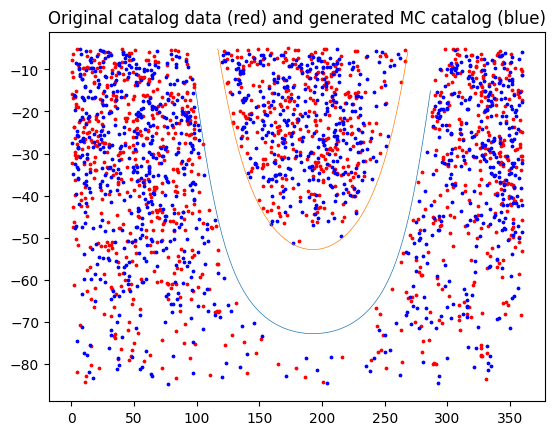

In [6]:
plt.scatter(df["RA"], df["DEC"], s=3, c="r")
plt.scatter(a[0][0], a[0][1], s=3, c="b")
plt.title("Original catalog data (red) and generated MC catalog (blue)")

l_interval = np.linspace(0, 360, 360) - np.linspace(136, 339, 360)
galactic_plane_upper = SkyCoord(l=l_interval*u.degree, b=-10*u.degree, frame='galactic')
galactic_plane_lower = SkyCoord(l=l_interval*u.degree, b=10*u.degree, frame='galactic')
plt.plot(galactic_plane_upper.icrs.ra, galactic_plane_upper.icrs.dec, linewidth=0.5, label="galactic plane1")
plt.plot(galactic_plane_lower.icrs.ra, galactic_plane_lower.icrs.dec, linewidth=0.5, label="galactic plane2")
plt.savefig("/mnt/c/Users/joerg/OneDrive/Dokumente/UNI/Bachelor of Science/Bachelorarbeit/Jupyter Notebook/Figures/MC_test.png", dpi=700)

## Trying another 2D KS-test:
The two different kd2d2s-tests seem to be very similar, but with slight differences. <br /> This most probably comes from the different implementation of the theory behind the two dimensional extension of the Kolmogorow-Smirnow-test. <br /> <br />
Additionally, values for the one dimensional ks-test (RA and DEC) are provided. <br />
The p-value of the RA seems to be extremly close to 1 all of the time, while the DEC p-value sometimes takes on values down to 0.5

In [7]:
for j in range(10):
    new_df = []
    for i in range(1177):
        new_df.append((np.array(a[j])[0][i],np.array(a[j])[1][i]))
    print(("{:.4f}".format(ks2d2s_2(np.array([[x for (x,y) in np.array(new_df)], [y for (x,y) in np.array(new_df)]]),np.array([[x for (x,y) in df.to_numpy()], [y for (x,y) in df.to_numpy()]]))[1]), "{:.4f}".format(ks2d2s_2(np.array([[x for (x,y) in np.array(new_df)],[y for (x,y) in np.array(new_df)]]),np.array([[x for (x,y) in df.to_numpy()],[y for (x,y) in df.to_numpy()]]))[0])))
    print("1D KS-test RA: " + ("{:.4f}".format(stats.kstest([x for (x,y) in np.array(new_df)], [x for (x,y) in df.to_numpy()])[1])), "  1D KS-test DEC: " +  "{:.4f}".format(stats.kstest([y for (x,y) in np.array(new_df)], [y for (x,y) in df.to_numpy()])[1]) + "\n")

('0.9392', '0.0268')
1D KS-test RA: 0.9999   1D KS-test DEC: 0.9163

('0.9647', '0.0251')
1D KS-test RA: 1.0000   1D KS-test DEC: 0.9783

('0.9941', '0.0212')
1D KS-test RA: 1.0000   1D KS-test DEC: 0.9999

('0.5391', '0.0404')
1D KS-test RA: 1.0000   1D KS-test DEC: 0.5381

('0.8856', '0.0293')
1D KS-test RA: 1.0000   1D KS-test DEC: 0.8393

('0.8750', '0.0297')
1D KS-test RA: 0.9997   1D KS-test DEC: 0.9535

('0.8036', '0.0323')
1D KS-test RA: 1.0000   1D KS-test DEC: 0.7102

('0.7906', '0.0327')
1D KS-test RA: 0.9997   1D KS-test DEC: 0.7773

('0.9698', '0.0246')
1D KS-test RA: 0.9997   1D KS-test DEC: 0.9783

('0.8526', '0.0306')
1D KS-test RA: 1.0000   1D KS-test DEC: 0.8092

